## Imports


In [1]:
from numpy import pi

import qutip as qt

from rich import print as pprint

import matplotlib
from matplotlib import colors, cm, patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from trical.light_matter import *
from trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

muted_palette = sns.color_palette("muted", n_colors=10, desat=0.8)

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 10,
)

transitions = [
    Transition(
        level1=downstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, -1],
    levels=[downstate, estate],
    transitions=transitions,
)
Yb171_2 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 1],
    levels=[downstate, estate],
    transitions=transitions,
)

COM_x = Phonon(
    energy=2 * np.pi * 0.1,
    eigenvector=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2), 0, 0],
)

system = System(
    ions=[Yb171, Yb171_2],
    modes=[COM_x],
)

In [4]:
Omega = 2 * np.pi * 0.002


mu = 2 * np.pi * 0.11


beam = Beam(
    transition=transitions[0],
    rabi=Omega,
    detuning=-mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)


beam2 = Beam(
    transition=transitions[0],
    rabi=Omega,
    detuning=mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)


beam3 = Beam(
    transition=transitions[0],
    rabi=Omega,
    detuning=-mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)


beam4 = Beam(
    transition=transitions[0],
    rabi=Omega,
    detuning=mu,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=1,
)


t = 4000
protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=t),
        Pulse(beam=beam2, duration=t),
        Pulse(beam=beam3, duration=t),
        Pulse(beam=beam4, duration=t),
    ]
)


circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [5]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("8a_example_direct_molmer_sorenson.json", "w") as f:
    f.write(circuit_json)

In [6]:
with open("8a_example_direct_molmer_sorenson.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [7]:
backend = QutipBackend(solver_options=dict(progress_bar="tqdm"))

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [8]:
from oqd_compiler_infrastructure import Post

from trical.light_matter.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(backend.intermediate))

AtomicEmulatorCircuit
  - frame: NoneType(None)
  - base: Operator(62.83185307179586 * |1><1|_E0 @ I_E1 @ I_P0 + 62.83185307179586 * I_E0 @ |1><1|_E1 @ I_P0 + 0.6283185307179586 * I_E0 @ I_E1 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(0.006283185307179586 * exp(1j * (-62.14070268800611 * t)) * |0><1|_E0 @ I_E1 @ D(2.9974929816782288 * exp(1j * (1.5707963267948966)))_P0 + 0.006283185307179586 * exp(1j * (-62.14070268800611 * t)) * |1><0|_E0 @ I_E1 @ D(2.9974929816782288 * exp(1j * (1.5707963267948966)))_P0 + 0.006283185307179586 * exp(1j * (62.14070268800611 * t)) * |0><1|_E0 @ I_E1 @ D(2.9974929816782288 * exp(1j * (-1.5707963267948966)))_P0 + 0.006283185307179586 * exp(1j * (62.14070268800611 * t)) * |1><0|_E0 @ I_E1 @ D(2.9974929816782288 * exp(1j * (-1.5707963267948966)))_P0 + 0.006283185307179586 * exp(1j * (-63.52300345558562 * t)) * |0><1|_E0 @ I_E1 @ D(3.0641712886518597 * exp(1j * (1.5707963267948966)))_P0 + 0.006283185307179586 

### Results


In [9]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-1,
)

  0%|          | 0/39999 [00:00<?, ?it/s]

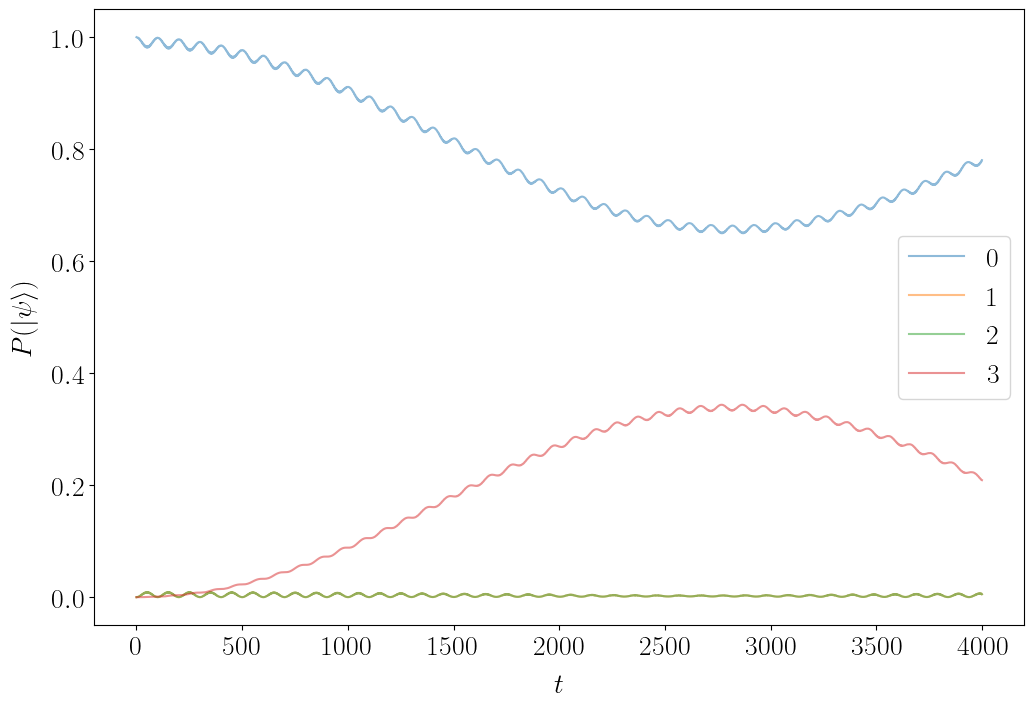

In [10]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

state_labels = [0, 1, 2, 3]
plot_states = [
    [s.ptrace([0, 1]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(result["tspan"][k], plot_states, label=range(len(state_labels)), alpha=0.5)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

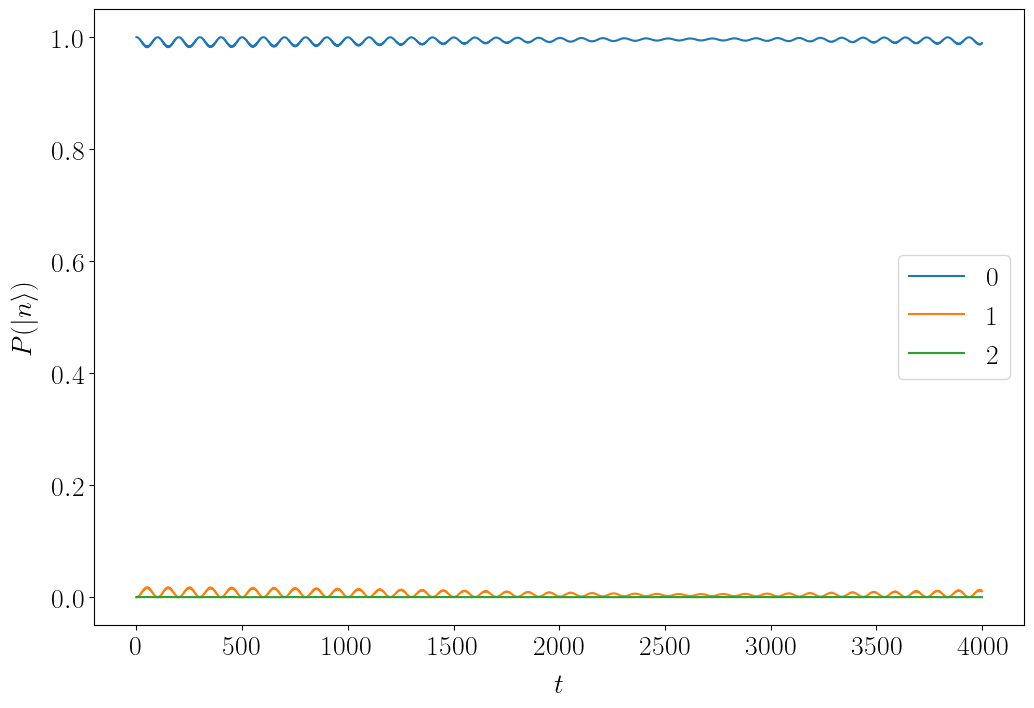

In [11]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(2).diag()[:fock_cutoff] for s in result["states"][k]],
    label=range(fock_cutoff),
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| n \rangle)$", labelpad=10)

ax.legend()